# Balance Sheet Manager - Position Data Analysis

## Contents

1. [Initial setup](#initial)
2. [Database Review](#initialdbrev)
3. [Data loading and dataframe creation](#dataload)
4. [Position Data Analysis](#dataanalysis)
    > 4.1 [Distribution of positions by Instrument Type](#piechart)  
    > 4.2 [Maturity distribution by Instrument Type](#maturity)  
    > 4.3 [Repricing frequency distribution](#rep)
        >> 4.3.1 [Floating](#rep_float)  
        >> 4.3.2 [Swap](#rep_swap)  
        >> 4.3.3 [CMB](#rep_cmb)  
        >> 4.3.2 [Credit Line Commitments](#rep_clc)
        
    > 4.4 [Coupon frequency distribution](#cou)
        >> 4.4.1 [Floating](#cou_float)  
        >> 4.4.2 [Fixed](#cou_fixed)  
        >> 4.4.3 [Swap](#cou_swap)  
        >> 4.4.4 [NMI](#cou_nmi)  
        >> 4.4.5 [CMB](#cou_cmb)  
        >> 4.4.6 [Credit Line Commitments](#cou_clc)
        
    > 4.5 [Compounding frequencies and capitalization](#com)
        >> 4.5.1 [Floating](#com_float)  
        >> 4.5.2 [Fixed](#com_fixed)  
        >> 4.5.3 [Swap](#com_swap)   
        >> 4.5.4 [CMB](#com_cmb)  
        >> 4.5.5 [Credit Line Commitments](#com_clc)

    > 4.6 [Amortization Type and Frequency distribution](#amort)  
        >> 4.6.1 [Floating](#amort_float)  
        >> 4.6.2 [Fixed](#amort_fixed)  
        >> 4.6.3 [Swap](#amort_swap)   
        >> 4.6.4 [CMB](#amort_cmb)  
        >> 4.6.5 [Credit Line Commitments](#amort_clc)
5. [Dimension Data Analysis](#dim)
    > 5.1 [Distinct dimension members for all Custom Dimensions + GL](#dim_func)
        >> 5.1.1 [Floating](#dim_float)  
        >> 5.1.2 [Fixed](#dim_fixed)  
        >> 5.1.3 [NMI](#dim_nmi)  
        >> 5.1.4 [Swap](#dim_swap)  
        >> 5.1.5 [CMB](#dim_cmb)  
        >> 5.1.6 [Credit Line Commitments](#dim_clc)  
        >> 5.1.7 [Repo Style Transactions](#dim_repo)  
        >> 5.1.8 [Generic Instruments](#dim_gen)  
        >> 5.1.9 [Credit Facilities](#dim_cf)

<a id='initial'></a>
## 1- Inital setup

In [1]:
#Import the relevant libraries

import pandas as pd
import numpy as np
import pyodbc 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Enter the relevant database information

server = 'CPC-PedroSeH-13\MSSQLSERVER_2017'
schema = 'dbo'
database = 'FeedSourceDB_2023_2_1'

In [3]:
#Connect to the database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server="+server+";"
                      "Database="+database+";"
                      "Trusted_Connection=yes;")

cursor = cnxn.cursor()

#Get list of tables in a database
tables_query = f"SELECT table_name FROM INFORMATION_SCHEMA.TABLES WHERE table_type = 'BASE TABLE'"
cursor.execute(tables_query)
tables = cursor.fetchall()

#Initialize lists to store table names and record counts
table_names = []
record_counts = []

#Get record count for each table
for table in tables:
    table_name = table[0]
    count_query = f"SELECT COUNT(*) FROM {table_name}"
    cursor.execute(count_query)
    record_count = cursor.fetchone()[0]
    table_names.append(table_name)
    record_counts.append(record_count)

#Create a DataFrame with table names and record counts
table_record_count = {'Table Name':table_names, 'Record Count': record_counts}
table_record_count_df = pd.DataFrame(table_record_count)


<a id='initialdbrev'></a>
## 2- Initial database review

,Table Name,Record Count
30,AdditionalInformationTable,956698
19,SpreadCurveValueTable,933011
2,FixedInstruments,911223
20,AmortizationTable,605803
26,DisbursementTable,143087
0,NonRateSensitiveInstruments,142550
31,MarginTable,94280
21,AmortizationPaymentTable,85412
5,Swaps,68005
25,RedemptionTable,54180


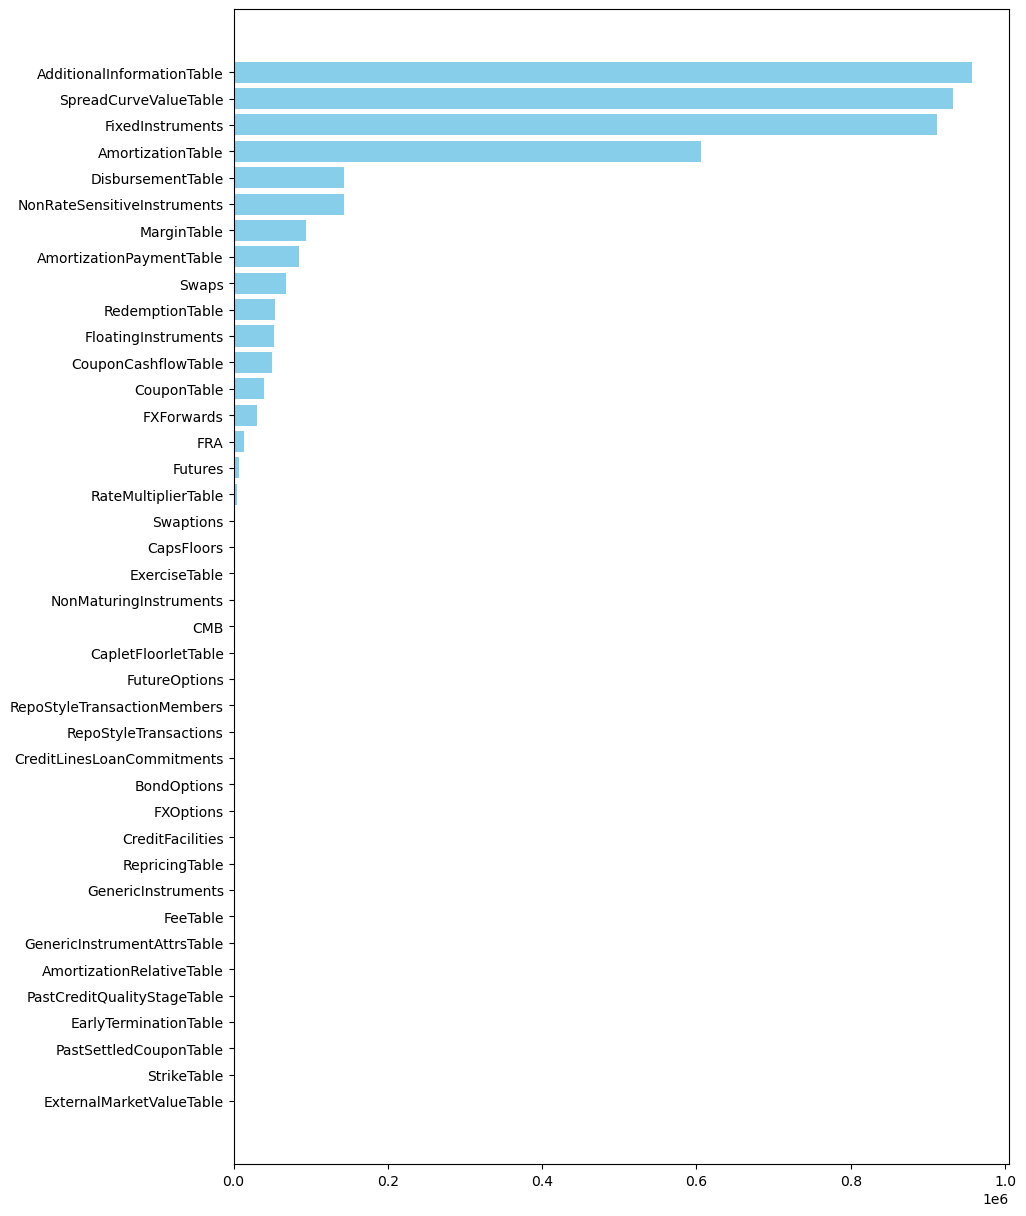

In [4]:
table_record_count_df = table_record_count_df.sort_values(by='Record Count', ascending=True)

plt.figure(figsize=(10,15))
plt.barh(table_record_count_df["Table Name"], table_record_count_df["Record Count"], color="skyblue")

table_record_count_df = table_record_count_df.sort_values(by='Record Count', ascending=False)

display(table_record_count_df)

<a id='dataload'></a>
## 3- Data loading and dataframe creation

In [5]:
#Load all the data
query = 'SELECT * FROM '+schema+'.[FixedInstruments]'
query1 = 'SELECT * FROM '+schema+'.[FloatingInstruments]'
query2 = 'SELECT * FROM '+schema+'.[Swaps]'
query3 = 'SELECT * FROM '+schema+'.[NonMaturingInstruments]'
query4 = 'SELECT * FROM '+schema+'.[GenericInstruments]'
query5 = 'SELECT * FROM '+schema+'.[CMB]'
query6 = 'SELECT * FROM '+schema+'.[CreditFacilities]'
query7 = 'SELECT * FROM '+schema+'.[CreditLinesLoanCommitments]'
query8 = 'SELECT * FROM '+schema+'.[RepoStyleTransactions]'


result_query = pd.read_sql(query, cnxn)
result_query1 = pd.read_sql(query1, cnxn)
result_query2 = pd.read_sql(query2, cnxn)
result_query3 = pd.read_sql(query3, cnxn)
result_query4 = pd.read_sql(query4, cnxn)
result_query5 = pd.read_sql(query5, cnxn)
result_query6 = pd.read_sql(query6, cnxn)
result_query7 = pd.read_sql(query7, cnxn)
result_query8 = pd.read_sql(query8, cnxn)

result_query = result_query.fillna(np.nan)
result_query1 = result_query1.fillna(np.nan)
result_query2 = result_query2.fillna(np.nan)
result_query3 = result_query3.fillna(np.nan)
result_query4 = result_query4.fillna(np.nan)
result_query5 = result_query5.fillna(np.nan)
result_query6 = result_query6.fillna(np.nan)
result_query7 = result_query7.fillna(np.nan)
result_query8 = result_query8.fillna(np.nan)

<a id='dataanalysis'></a>
## 4- Position Data Analysis

<a id='piechart'></a>
### 4.1- Pie chart with the distribution of Instrument Types

Table: Count of records by Instrument Type


,InstrumentType,Record Count
0,Fixed,911223
1,Float,51999
2,Swaps,68005
3,NMI,435
5,CMB,125


Total records:  1031787


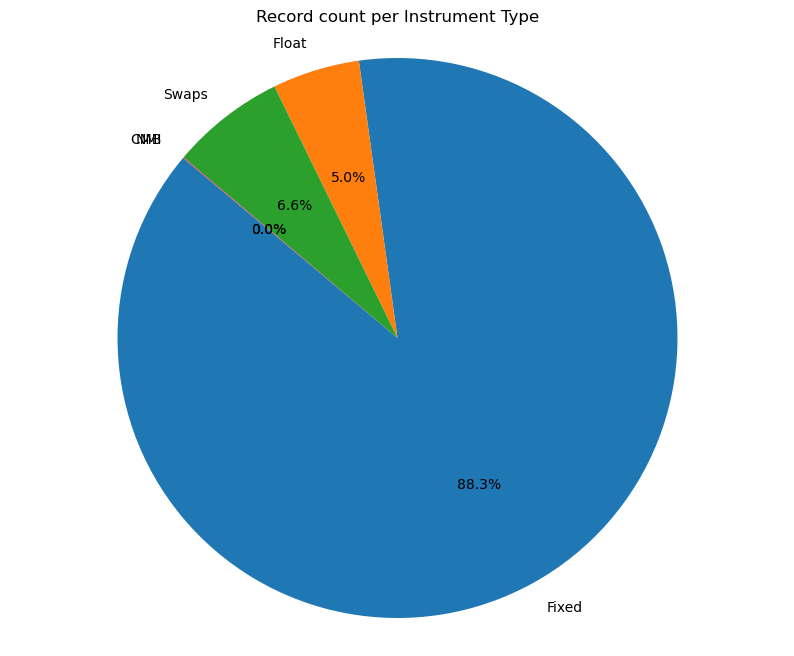

In [6]:
#1- Pie chart with the distribution of Instrument Types

dfs = [result_query,result_query1,result_query2,result_query3,result_query4,result_query5, result_query6, result_query7, result_query8]
record_counts = [len(df) for df in dfs]

labels = ['Fixed', 'Float', 'Swaps', 'NMI', 'GenericInstruments', 'CMB', 'CrediFacilities', 'CreditLinesLoanCommitments', 'RepoStyleTransactions']

data_count = {'InstrumentType':labels, 'Record Count':record_counts}
df_count = pd.DataFrame(data_count)

total_records = df_count["Record Count"].sum()

df_count_filtered = df_count[df_count["Record Count"] != 0]

plt.figure(figsize=(10,8))
plt.pie(df_count_filtered["Record Count"],labels=df_count_filtered["InstrumentType"],autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Record count per Instrument Type')

print('Table: Count of records by Instrument Type')
display(df_count_filtered)
print(f"Total records:  {total_records}")

<a id='maturity'></a>
### 4.2-  Maturity distribution by Instrument Type

<Axes: xlabel='EndDate_Year', ylabel='Count'>

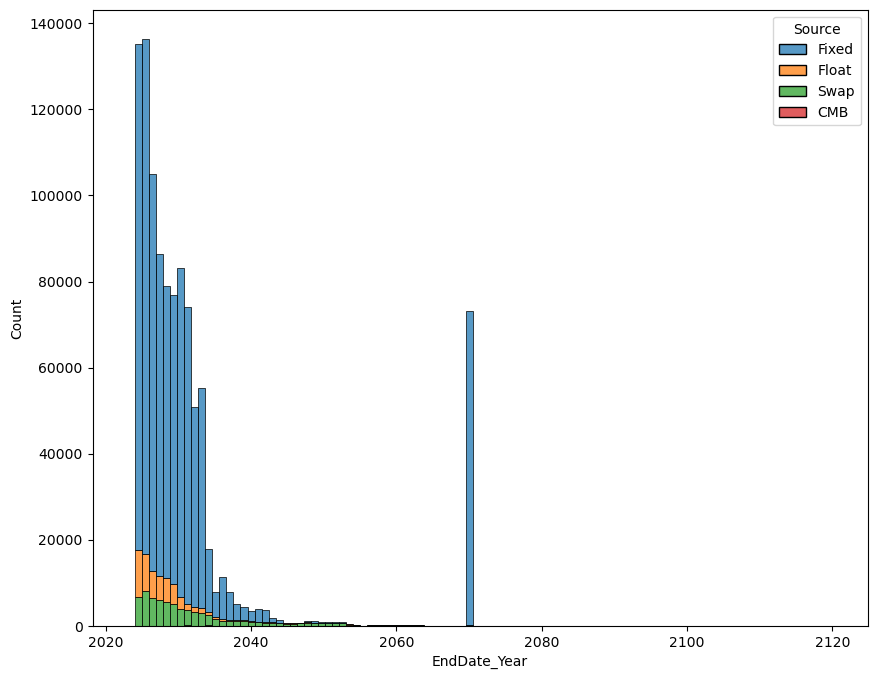

In [7]:
#2- Maturity distribution - Create a function that retrieves the maturity distribution of a 
#combined dataset with all instrument types. Shows a histogram with the distribution by IT

result_query["EndDate"] = pd.to_datetime(result_query["EndDate"])
result_query['EndDate_Year'] = pd.DatetimeIndex(result_query['EndDate']).year

result_query1["EndDate"] = pd.to_datetime(result_query1["EndDate"])
result_query1['EndDate_Year'] = pd.DatetimeIndex(result_query1['EndDate']).year

result_query2["EndDate"] = pd.to_datetime(result_query2["EndDate"])
result_query2['EndDate_Year'] = pd.DatetimeIndex(result_query2['EndDate']).year

result_query5["EndDate"] = pd.to_datetime(result_query5["EndDate"])
result_query5['EndDate_Year'] = pd.DatetimeIndex(result_query5['EndDate']).year

result_query6["EndDate"] = pd.to_datetime(result_query6["EndDate"])
result_query6['EndDate_Year'] = pd.DatetimeIndex(result_query6['EndDate']).year

result_query7["EndDate"] = pd.to_datetime(result_query7["EndDate"])
result_query7['EndDate_Year'] = pd.DatetimeIndex(result_query7['EndDate']).year

result_query8["EndDate"] = pd.to_datetime(result_query8["EndDate"])
result_query8['EndDate_Year'] = pd.DatetimeIndex(result_query8['EndDate']).year


mat_dist = pd.concat([
result_query["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='Fixed'),
result_query1["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='Float'),
result_query2["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='Swap'),
result_query5["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='CMB'),
result_query6["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='CreditFacilities'),
result_query7["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='CreditLinesLoanCommitments'),
result_query8["EndDate_Year"].rename('EndDate_Year').to_frame().assign(Source='RepoStyleTransactions')
])

plt.figure(figsize=(10,8))
sns.histplot(data=mat_dist, x= "EndDate_Year", hue='Source', multiple='stack', palette='tab10', bins=100)

In [8]:
Maturity_df = mat_dist.groupby(by=["Source", "EndDate_Year"],dropna=False).size().reset_index(name='Count')
display(Maturity_df)

,Source,EndDate_Year,Count
0,CMB,2024,6
1,CMB,2025,2
2,CMB,2026,1
3,CMB,2027,4
4,CMB,2028,4
5,CMB,2029,9
6,CMB,2030,8
7,CMB,2031,29
8,CMB,2032,1
9,CMB,2033,4


<a id='rep'></a>
### 4.3-  Repricing frequency distribution

<a id='rep_float'></a>
#### 4.3.1- Floating Instruments

In [9]:
#3- Repricing frequencies distribution - Create a function that shows the distribution of repricing
#frequencies for Floating instruments and Swaps. Fields to consider:
#Floating, CMB: Repricing_MarginType, Repricing_RateModel, Repricing_IsAverageRate, Repricing_FreqTimeBase, Repricing_Freq
#Swaps: PayRepricing_IsAverageRate, PayRepricing_RateModel, PayRepricing_RateModel, PayRepricing_FreqTimeBase,PayRepricing_Freq, RecRepricing_IsAverageRate, RecRepricing_FreqTimeBase,RecRepricing_Freq 
#CreditLineCommitments: DrawnAmountFixFloat, Repricing_FreqTimeBase, Repricing_Freq

#result_query1 - Floating
#result_query5 - CMB
#result_query2 - Swaps
#result_query7 - CL Commitments

#Floating
print("Floating instruments: Repricing distribution")
Float_Repricing = result_query1.groupby(by=["Repricing_MarginType", "Repricing_RateModel", "Repricing_IsAverageRate", "Repricing_FreqTimeBase", "Repricing_Freq"],dropna=False).size().reset_index(name='Count')
display(Float_Repricing)

Floating instruments: Repricing distribution


,Repricing_MarginType,Repricing_RateModel,Repricing_IsAverageRate,Repricing_FreqTimeBase,Repricing_Freq,Count
0,1,NaN,False,1,1,91
1,1,NaN,False,2,1,1
2,1,NaN,False,3,1,1872
3,1,NaN,False,3,3,45244
4,1,NaN,False,3,6,3477
5,1,NaN,False,3,12,338
6,1,NaN,False,4,1,35
7,1,NaN,True,1,1,544
8,2,NaN,False,3,1,16
9,2,NaN,False,3,3,106


<a id='rep_swap'></a>
#### 4.3.2- Swaps

In [10]:
#Swaps
print("Swaps instruments: Repricing distribution")

Swaps_Repricing = result_query2.groupby(by=["PayRepricing_IsAverageRate","PayRepricing_RateModel","PayRepricing_FreqTimeBase","PayRepricing_Freq", "RecRepricing_IsAverageRate", "RecRepricing_RateModel", "RecRepricing_FreqTimeBase","RecRepricing_Freq"], dropna=False).size().reset_index(name='Count')
display(Swaps_Repricing)

Swaps instruments: Repricing distribution


,PayRepricing_IsAverageRate,PayRepricing_RateModel,PayRepricing_FreqTimeBase,PayRepricing_Freq,RecRepricing_IsAverageRate,RecRepricing_RateModel,RecRepricing_FreqTimeBase,RecRepricing_Freq,Count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399
1,NaN,NaN,NaN,NaN,False,NaN,1.000,1.000,24
2,NaN,NaN,NaN,NaN,False,NaN,3.000,1.000,1092
3,NaN,NaN,NaN,NaN,False,NaN,3.000,3.000,11358
4,NaN,NaN,NaN,NaN,False,NaN,3.000,6.000,10534
5,NaN,NaN,NaN,NaN,False,NaN,3.000,12.000,28
6,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,30
7,NaN,NaN,NaN,NaN,True,NaN,1.000,1.000,5338
8,False,NaN,1.000,1.000,NaN,NaN,NaN,NaN,26
9,False,NaN,1.000,1.000,True,NaN,1.000,1.000,2


<a id='rep_cmb'></a>
#### 4.3.3- CMBs

In [11]:
#CMBs
print("CMBs instruments: Repricing distribution")

CMB_Repricing = result_query5.groupby(by=["Repricing_MarginType", "Repricing_IsAverageRate", "Repricing_FreqTimeBase", "Repricing_Freq"], dropna=False).size().reset_index(name='Count')
display(CMB_Repricing)

CMBs instruments: Repricing distribution


,Repricing_MarginType,Repricing_IsAverageRate,Repricing_FreqTimeBase,Repricing_Freq,Count
0,1,False,3,12,54
1,2,False,3,12,71


<a id='rep_clc'></a>
#### 4.3.4- CL Commitments

In [12]:
#CL Commitments
print("CL Commitments instruments: Repricing distribution")

CL_Repricing = result_query7.groupby(by=["DrawnAmountFixFloat", "Repricing_FreqTimeBase", "Repricing_Freq"], dropna=False).size().reset_index(name='Count')
display(CL_Repricing)

CL Commitments instruments: Repricing distribution


,DrawnAmountFixFloat,Repricing_FreqTimeBase,Repricing_Freq,Count


<a id='cou'></a>
### 4.4-  Coupon frequency distribution

<a id='cou_float'></a>
#### 4.4.1- Floating Instruments

In [13]:
#Floating
print("Floating instruments: Coupon frequency distribution")
Float_Coupon = result_query1.groupby(by=["Coupon_PaymentFreqTimeBase", "Coupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Float_Coupon)

Floating instruments: Coupon frequency distribution


,Coupon_PaymentFreqTimeBase,Coupon_PaymentFreq,Count
0,1.000,1.000,36
1,3.000,1.000,9319
2,3.000,3.000,25105
3,3.000,6.000,3530
4,3.000,7.000,3
5,3.000,12.000,580
6,4.000,1.000,15
7,99.000,NaN,13409
8,NaN,NaN,2


<a id='cou_fixed'></a>
#### 4.4.2- Fixed Instruments

In [14]:
#Fixed
print("Fixed instruments: Coupon frequency distribution")
Fixed_Coupon = result_query.groupby(by=["Coupon_PaymentFreqTimeBase", "Coupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Fixed_Coupon)

Fixed instruments: Coupon frequency distribution


,Coupon_PaymentFreqTimeBase,Coupon_PaymentFreq,Count
0,1.000,1.000,169
1,2.000,1.000,9
2,3.000,1.000,604085
3,3.000,3.000,173424
4,3.000,5.000,1
5,3.000,6.000,3365
6,3.000,7.000,1
7,3.000,8.000,1
8,3.000,9.000,5
9,3.000,10.000,2


<a id='cou_swap'></a>
#### 4.4.3- Swap Instruments

In [15]:
#Swaps
print("Swap instruments: Coupon frequency distribution")
Swap_Coupon = result_query2.groupby(by=["PayCoupon_PaymentFreqTimeBase", "PayCoupon_PaymentFreq", "RecCoupon_PaymentFreqTimeBase", "RecCoupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Swap_Coupon)

Swap instruments: Coupon frequency distribution


,PayCoupon_PaymentFreqTimeBase,PayCoupon_PaymentFreq,RecCoupon_PaymentFreqTimeBase,RecCoupon_PaymentFreq,Count
0,3.000,1.000,3.000,1.000,1014
1,3.000,1.000,3.000,3.000,43
2,3.000,1.000,3.000,6.000,215
3,3.000,1.000,3.000,12.000,854
4,3.000,1.000,99.000,NaN,35
5,3.000,3.000,3.000,1.000,38
6,3.000,3.000,3.000,3.000,7060
7,3.000,3.000,3.000,6.000,1186
8,3.000,3.000,3.000,12.000,11028
9,3.000,3.000,99.000,NaN,38


<a id='cou_nmi'></a>
#### 4.4.4- Non Maturing Instruments

In [16]:
#NMI
print("NMI instruments: Coupon frequency distribution")
NMI_Coupon = result_query3.groupby(by=["Coupon_PaymentFreqTimeBase", "Coupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(NMI_Coupon)

NMI instruments: Coupon frequency distribution


,Coupon_PaymentFreqTimeBase,Coupon_PaymentFreq,Count
0,3,1,220
1,3,3,206
2,3,6,1
3,4,1,8


<a id='cou_cmb'></a>
#### 4.4.5- CMB Instruments

In [17]:
#CMB
print("CMB instruments: Coupon frequency distribution")
CMB_Coupon = result_query5.groupby(by=["Coupon_PaymentFreqTimeBase", "Coupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(CMB_Coupon)

CMB instruments: Coupon frequency distribution


,Coupon_PaymentFreqTimeBase,Coupon_PaymentFreq,Count
0,3,12,125


<a id='cou_clc'></a>
#### 4.4.6- CreditLineCommitments

In [18]:
#CLC
print("CL Commitment instruments: Coupon frequency distribution")
CLM_Coupon = result_query7.groupby(by=["DrawnAmountFixFloat","Coupon_PaymentFreqTimeBase", "Coupon_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(CLM_Coupon)

CL Commitment instruments: Coupon frequency distribution


,DrawnAmountFixFloat,Coupon_PaymentFreqTimeBase,Coupon_PaymentFreq,Count


<a id='com'></a>
### 4.5- Compounding frequencies and capitalization

<a id='com_float'></a>
#### 4.5.1- Floating Instruments

In [19]:
#Floating
print("Floating instruments: Compounding frequency distribution")
Float_Comp = result_query1.groupby(by=["Coupon_CapitalizeOnPrincipal","Coupon_CompoundFreqTimeBase", "Coupon_CompoundFreq"],dropna=False).size().reset_index(name='Count')
display(Float_Comp)

Floating instruments: Compounding frequency distribution


,Coupon_CapitalizeOnPrincipal,Coupon_CompoundFreqTimeBase,Coupon_CompoundFreq,Count
0,1,3.000,3.000,56
1,2,3.000,3.000,5
2,2,3.000,12.000,3
3,2,NaN,NaN,51935


<a id='com_fixed'></a>
#### 4.5.2- Fixed Instruments

In [20]:
#Fixed
print("Fixed instruments: Compounding frequency distribution")
Fixed_Comp = result_query.groupby(by=["Coupon_CapitalizeOnPrincipal","Coupon_CompoundFreqTimeBase", "Coupon_CompoundFreq"],dropna=False).size().reset_index(name='Count')
display(Fixed_Comp)

Fixed instruments: Compounding frequency distribution


,Coupon_CapitalizeOnPrincipal,Coupon_CompoundFreqTimeBase,Coupon_CompoundFreq,Count
0,1,3.000,1.000,70
1,1,3.000,3.000,14
2,1,3.000,12.000,11
3,1,NaN,NaN,139
4,2,3.000,3.000,2
5,2,NaN,NaN,910987


<a id='com_swap'></a>
#### 4.5.3- Swap Instruments

In [21]:
#Swap
print("Swap instruments: Compounding frequency distribution")
Swap_Comp = result_query2.groupby(by=["PayCoupon_CapitalizeOnPrincipal", "PayCoupon_CompoundFreqTimeBase", "PayCoupon_CompoundFreq", "RecCoupon_CapitalizeOnPrincipal", "RecCoupon_CompoundFreqTimeBase", "RecCoupon_CompoundFreq"],dropna=False).size().reset_index(name='Count')
display(Swap_Comp)

Swap instruments: Compounding frequency distribution


,PayCoupon_CapitalizeOnPrincipal,PayCoupon_CompoundFreqTimeBase,PayCoupon_CompoundFreq,RecCoupon_CapitalizeOnPrincipal,RecCoupon_CompoundFreqTimeBase,RecCoupon_CompoundFreq,Count
0,1,1.000,1.000,2,NaN,NaN,2
1,1,3.000,6.000,1,3.000,6.000,1
2,2,3.000,3.000,2,NaN,NaN,428
3,2,NaN,NaN,1,1.000,1.000,2
4,2,NaN,NaN,1,3.000,12.000,1
5,2,NaN,NaN,2,3.000,3.000,342
6,2,NaN,NaN,2,NaN,NaN,67229


<a id='com_cmb'></a>
#### 4.5.4- CMB Instruments

In [22]:
#CMB
print("Floating instruments: Compounding frequency distribution")
CMB_Comp = result_query5.groupby(by=["Coupon_CapitalizeOnPrincipal","Coupon_CompoundFreqTimeBase", "Coupon_CompoundFreq"],dropna=False).size().reset_index(name='Count')
display(CMB_Comp)

Floating instruments: Compounding frequency distribution


,Coupon_CapitalizeOnPrincipal,Coupon_CompoundFreqTimeBase,Coupon_CompoundFreq,Count
0,2,NaN,NaN,125


<a id='com_clc'></a>
#### 4.5.5- CL Commitments

In [23]:
#CLC
print("CL Commitments instruments: Compounding frequency distribution")
CLC_Comp = result_query7.groupby(by=["DrawnAmountFixFloat","Coupon_CapitalizeOnPrincipal","Coupon_CompoundFreqTimeBase", "Coupon_CompoundFreq"],dropna=False).size().reset_index(name='Count')
display(CLC_Comp)

CL Commitments instruments: Compounding frequency distribution


,DrawnAmountFixFloat,Coupon_CapitalizeOnPrincipal,Coupon_CompoundFreqTimeBase,Coupon_CompoundFreq,Count


<a id='amort'></a>
### 4.6- Amortization type distribution

<a id='amort_float'></a>
#### 4.6.1- Floating Instruments

In [24]:
#Floating
print("Floating instruments: Amortization distribution")
Float_Amort = result_query1.groupby(by=["Amort_Type", "EarlyTerminationType", "Amort_PaymentFreqTimeBase", "Amort_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Float_Amort)

Floating instruments: Amortization distribution


,Amort_Type,EarlyTerminationType,Amort_PaymentFreqTimeBase,Amort_PaymentFreq,Count
0,1,1,NaN,NaN,37763
1,2,1,3.000,1.000,5195
2,2,1,3.000,3.000,283
3,2,1,3.000,6.000,27
4,3,1,3.000,1.000,501
5,3,1,3.000,3.000,1167
6,3,1,3.000,6.000,1295
7,3,1,3.000,12.000,7
8,3,1,4.000,1.000,37
9,6,1,NaN,NaN,5724


<a id='amort_fixed'></a>
#### 4.6.2- Fixed Instruments

In [25]:
#Fixed
print("Fixed instruments: Amortization distribution")
Fixed_Amort = result_query.groupby(by=["Amort_Type", "EarlyTerminationType", "Amort_PaymentFreqTimeBase", "Amort_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Fixed_Amort)

Fixed instruments: Amortization distribution


,Amort_Type,EarlyTerminationType,Amort_PaymentFreqTimeBase,Amort_PaymentFreq,Count
0,1,1,NaN,NaN,169428
1,2,1,3.000,1.000,482463
2,2,1,3.000,3.000,51974
3,2,1,3.000,6.000,947
4,2,1,4.000,1.000,94
5,3,1,3.000,1.000,83982
6,3,1,3.000,3.000,116595
7,3,1,3.000,6.000,3317
8,3,1,4.000,1.000,668
9,6,1,NaN,NaN,1755


<a id='amort_swap'></a>
#### 4.6.3- Swaps Instruments

In [26]:
#Swaps
print("Swaps instruments: Amortization distribution")
Swap_Amort = result_query2.groupby(by=["EarlyTerminationType", "PayAmort_Type", "PayAmort_PaymentFreqTimeBase", "PayAmort_PaymentFreq", "RecAmort_Type", "RecAmort_PaymentFreqTimeBase", "RecAmort_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(Swap_Amort)

Swaps instruments: Amortization distribution


,EarlyTerminationType,PayAmort_Type,PayAmort_PaymentFreqTimeBase,PayAmort_PaymentFreq,RecAmort_Type,RecAmort_PaymentFreqTimeBase,RecAmort_PaymentFreq,Count
0,1,1,NaN,NaN,1,NaN,NaN,60197
1,1,1,NaN,NaN,6,NaN,NaN,58
2,1,6,NaN,NaN,1,NaN,NaN,8
3,1,6,NaN,NaN,6,NaN,NaN,7742


<a id='amort_cmb'></a>
#### 4.6.4- CMB Instruments

In [27]:
#CMB
print("CMB instruments: Amortization distribution")
CMB_Amort = result_query5.groupby(by=["Amort_Type", "EarlyTerminationType", "Amort_PaymentFreqTimeBase", "Amort_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(CMB_Amort)

CMB instruments: Amortization distribution


,Amort_Type,EarlyTerminationType,Amort_PaymentFreqTimeBase,Amort_PaymentFreq,Count
0,1,1,NaN,NaN,125


<a id='amort_clc'></a>
#### 4.6.5- CL Commitments Instruments

In [28]:
#CLC
print("CL Commitments instruments: Amortization distribution")
CLC_Amort = result_query7.groupby(by=["DrawnAmountFixFloat","Amort_Type", "EarlyTerminationType", "Amort_PaymentFreqTimeBase", "Amort_PaymentFreq"],dropna=False).size().reset_index(name='Count')
display(CLC_Amort)

CL Commitments instruments: Amortization distribution


,DrawnAmountFixFloat,Amort_Type,EarlyTerminationType,Amort_PaymentFreqTimeBase,Amort_PaymentFreq,Count


<a id='dim'></a>
## 5- Dimension Data Analysis

<a id='dim_func'></a>
### 5.1- Distinct dimension members for all Custom Dimensions + GL

In [29]:
def analyze_dimensions(df):
    dimension_cols_noCA = [col for col in df if col.startswith(("CD_")) or col == "LedgerAccount"]
    dimension_cols_CA = [col for col in df if col.startswith(("CD_", "CA_")) or col == "LedgerAccount"]

    distinct_counts = df[dimension_cols_CA].apply(lambda x:x.nunique()).to_frame().reset_index()
    distinct_counts.columns = ["Dimension", "Distinct_Values_Count"]

    display(distinct_counts)

    grouped_dim = df.groupby(dimension_cols_noCA,dropna=False).size().reset_index(name="Record_Count")
    display(grouped_dim)
    

<a id='dim_float'></a>
#### 5.1.1- Floating Instruments

In [30]:
analyze_dimensions(result_query1)

,Dimension,Distinct_Values_Count
0,LedgerAccount,68
1,CA_CallNotice,1
2,CA_Kst_ID,214
3,CA_ZBS_NR,270
4,CD_AccountType,1
5,CD_Aufrechnung_H,2
6,CD_AusschlussListe_H,2
7,CD_B3M_Z,1
8,CD_BaselIIRiskWeight,1
9,CD_Besicherungsverhaeltnis_L,2


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
0,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,2,0,2,0,0,Undefined,1
1,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,2,0,2,0,0,Undefined,1
2,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,2,0,2,0,0,Undefined,1
3,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,2,0,2,0,0,Undefined,2
4,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,2,0,2,0,0,Undefined,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8124,SI Money Market L,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,20103,Undefined,Undefined,2,0,0,0,0,Undefined,1
8125,SI Money Market L,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,20103,Undefined,Undefined,2,0,0,4,0,Undefined,99
8126,SI Money Market L,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,20103,Undefined,Undefined,2,0,0,4,0,Undefined,84
8127,SI Money Market L,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,20103,Undefined,Undefined,2,0,0,4,0,Undefined,1


<a id='dim_fixed'></a>
#### 5.1.2- Fixed Instruments

In [31]:
analyze_dimensions(result_query)

,Dimension,Distinct_Values_Count
0,LedgerAccount,74
1,CA_CallNotice,8
2,CA_Kst_ID,242
3,CA_ZBS_NR,466
4,CD_AccountType,1
5,CD_Aufrechnung_H,2
6,CD_AusschlussListe_H,2
7,CD_B3M_Z,1
8,CD_BaselIIRiskWeight,1
9,CD_Besicherungsverhaeltnis_L,2


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
0,"Anleihen, Schuldverschr. Fix ungedeckt",Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,25100,Undefined,Undefined,1,3,0,0,0,Undefined,1
1,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,08,0,1111,...,50100,Undefined,Undefined,1,0,0,0,0,Undefined,1
2,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,1,0,0,0,0,Undefined,1
3,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,1,0,0,0,0,Undefined,1
4,Cashflow exklusive Impairment,Undefined,0,0,Undefined,Undefined,0,09,0,1111,...,50100,Undefined,Undefined,1,0,0,0,0,Undefined,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32388,sonstige Sparprodukte,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,15100,Undefined,Undefined,1,0,0,0,0,Undefined,1
32389,sonstige Sparprodukte,Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,15100,Undefined,Undefined,1,0,0,1,0,Undefined,1
32390,sonstige Sparprodukte,Undefined,0,1,Undefined,Undefined,0,99,0,1111,...,15100,Undefined,Undefined,1,0,0,0,0,Undefined,1
32391,sonstige Sparprodukte,Undefined,0,1,Undefined,Undefined,0,99,0,1111,...,15100,Undefined,Undefined,1,0,0,0,0,Undefined,2


<a id='dim_nmi'></a>
#### 5.1.3- NMI Instruments

In [32]:
analyze_dimensions(result_query3)

,Dimension,Distinct_Values_Count
0,LedgerAccount,24
1,CA_CallNotice,0
2,CA_Kst_ID,4
3,CA_ZBS_NR,0
4,CD_AccountType,1
5,CD_Aufrechnung_H,1
6,CD_AusschlussListe_H,1
7,CD_B3M_Z,1
8,CD_BaselIIRiskWeight,1
9,CD_Besicherungsverhaeltnis_L,2


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
0,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10201,Undefined,Undefined,1,0,0,0,0,Undefined,2
1,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10202,Undefined,Undefined,1,0,0,0,0,Undefined,2
2,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10201,Undefined,Undefined,1,0,0,0,0,Undefined,1
3,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10202,Undefined,Undefined,1,0,0,0,0,Undefined,1
4,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10300,Undefined,Undefined,1,0,0,0,0,Undefined,1
5,Anlagekto. geldmarktnahe Verz. Schwankungsbreite,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,15304,Undefined,Undefined,1,0,0,0,0,Undefined,1
6,Anlagekto. geldmarktnahe Verzinsung,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10201,Undefined,Undefined,1,0,0,0,0,Undefined,1
7,Anlagekto. geldmarktnahe Verzinsung,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10202,Undefined,Undefined,1,0,0,0,0,Undefined,1
8,Anlagekto. geldmarktnahe Verzinsung,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,10300,Undefined,Undefined,1,0,0,0,0,Undefined,1
9,Anlagekto. geldmarktnahe Verzinsung,Undefined,0,0,Undefined,Undefined,Undefined,99,0,1111,...,15304,Undefined,Undefined,1,0,0,0,0,Undefined,1


<a id='dim_swap'></a>
#### 5.1.4- Swap Instruments

In [33]:
analyze_dimensions(result_query2)

,Dimension,Distinct_Values_Count
0,LedgerAccount,8
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,176
4,CD_AccountType,1
5,CD_Aufrechnung_H,1
6,CD_AusschlussListe_H,1
7,CD_B3M_Z,1
8,CD_BaselIIRiskWeight,1
9,CD_Besicherungsverhaeltnis_L,1


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
0,H Zinsderivate,Undefined,0,0,Undefined,Undefined,0,99,0,2212,...,70201,Undefined,Undefined,8_Payer,9,9,9,9,Undefined,16
1,H Zinsderivate,Undefined,0,0,Undefined,Undefined,0,99,0,2212,...,70201,Undefined,Undefined,8_Receiver,9,9,9,9,Undefined,16
2,H Zinsderivate,Undefined,0,0,Undefined,Undefined,0,99,0,2212,...,70201,Undefined,Undefined,8_Payer,9,9,9,9,Undefined,1
3,H Zinsderivate,Undefined,0,0,Undefined,Undefined,0,99,0,2212,...,70201,Undefined,Undefined,8_Receiver,9,9,9,9,Undefined,2
4,H Zinsderivate,Undefined,0,0,Undefined,Undefined,0,99,0,2212,...,70201,Undefined,Undefined,8_Payer,9,9,9,9,Undefined,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,SI Mikro Swap (inkl. Hedge Nr.),Undefined,0,0,Undefined,Undefined,0,99,0,1111,...,70200,Undefined,Undefined,8_Receiver,9,9,9,9,Undefined,1
2020,SI Mikro Swap (inkl. Hedge Nr.),Undefined,0,0,Undefined,Undefined,0,99,0,1121,...,70200,Undefined,Undefined,8_Receiver,9,9,9,9,Undefined,3
2021,SI Mikro Swap (inkl. Hedge Nr.),Undefined,0,0,Undefined,Undefined,0,99,0,1121,...,70201,Undefined,Undefined,8_Payer,9,9,9,9,Undefined,216
2022,SI Mikro Swap (inkl. Hedge Nr.),Undefined,0,0,Undefined,Undefined,0,99,0,1121,...,70200,Undefined,Undefined,8_Receiver,9,9,9,9,Undefined,2


<a id='dim_cmb'></a>
#### 5.1.5- CMB Instruments

In [34]:
analyze_dimensions(result_query5)

,Dimension,Distinct_Values_Count
0,LedgerAccount,4
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,7
4,CD_AccountType,1
5,CD_Aufrechnung_H,2
6,CD_AusschlussListe_H,1
7,CD_B3M_Z,1
8,CD_BaselIIRiskWeight,1
9,CD_Besicherungsverhaeltnis_L,1


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
0,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25104,Undefined,Undefined,4,0,0,0,2,Undefined,2
1,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25104,Undefined,Undefined,4,0,0,0,2,Undefined,2
2,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25201,Undefined,Undefined,2,0,0,0,2,Undefined,1
3,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25100,Undefined,Undefined,4,0,0,0,2,Undefined,1
4,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25100,Undefined,Undefined,4,0,0,0,2,Undefined,1
5,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25100,Undefined,Undefined,4,0,0,0,2,Undefined,1
6,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25100,Undefined,Undefined,4,0,0,0,2,Undefined,1
7,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25104,Undefined,Undefined,4,0,0,0,2,Undefined,1
8,H Anleihen / Schuldver. A,Undefined,0,0,Undefined,Undefined,0,99,0,2222,...,25100,Undefined,Undefined,2,0,0,0,2,Undefined,1
9,H Anleihen / Schuldver. A,Undefined,1,0,Undefined,Undefined,0,99,0,2212,...,25100,Undefined,Undefined,2,0,3,0,2,Undefined,16


<a id='dim_clc'></a>
#### 5.1.6- CL Commitments Instruments

In [35]:
analyze_dimensions(result_query7)

,Dimension,Distinct_Values_Count
0,LedgerAccount,0
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,0
4,CD_AccountType,0
5,CD_Aufrechnung_H,0
6,CD_AusschlussListe_H,0
7,CD_B3M_Z,0
8,CD_BaselIIRiskWeight,0
9,CD_Besicherungsverhaeltnis_L,0


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count


<a id='dim_repo'></a>
#### 5.1.7- Repo Instruments

In [36]:
analyze_dimensions(result_query8)

,Dimension,Distinct_Values_Count
0,LedgerAccount,0
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,0
4,CD_AccountType,0
5,CD_Aufrechnung_H,0
6,CD_AusschlussListe_H,0
7,CD_B3M_Z,0
8,CD_BaselIIRiskWeight,0
9,CD_Besicherungsverhaeltnis_L,0


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count


<a id='dim_gen'></a>
#### 5.1.8- Generic Instruments

In [37]:
analyze_dimensions(result_query4)

,Dimension,Distinct_Values_Count
0,LedgerAccount,0
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,0
4,CD_AccountType,0
5,CD_Aufrechnung_H,0
6,CD_AusschlussListe_H,0
7,CD_B3M_Z,0
8,CD_BaselIIRiskWeight,0
9,CD_Besicherungsverhaeltnis_L,0


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count


<a id='dim_cf'></a>
#### 5.1.9- Credit Facilities

In [38]:
analyze_dimensions(result_query6)

,Dimension,Distinct_Values_Count
0,LedgerAccount,0
1,CA_CallNotice,0
2,CA_Kst_ID,0
3,CA_ZBS_NR,0
4,CD_AccountType,0
5,CD_Aufrechnung_H,0
6,CD_AusschlussListe_H,0
7,CD_B3M_Z,0
8,CD_BaselIIRiskWeight,0
9,CD_Besicherungsverhaeltnis_L,0


,LedgerAccount,CD_AccountType,CD_Aufrechnung_H,CD_AusschlussListe_H,CD_B3M_Z,CD_BaselIIRiskWeight,CD_Besicherungsverhaeltnis_L,CD_Bewertungs_Relevanz,CD_Brutto_CF_M,CD_Buch,...,CD_ZAHL_ProdNr,CD_Zahlungsausfall_L,CD_Zahlungsmonat_L,CD_ZinsArt_Charakter,CD_ZinsArt_Konditionen,CD_ZinsArt_ZinsBegrenzung,CD_ZinsArt_ZinsKapitalisierung,CD_ZinsArt_ZinsMethode,CD_ZVP_ID_T,Record_Count
